In [1]:
# Load necessary modules and dataset 
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyber-gpu/lib/python3.10/site-packages")

import matplotlib.pyplot as plt
from functions import *
from utils import *

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".1"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"  # add this
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

jax.config.update("jax_enable_x64", True)

In [2]:
# Load the data from the dataset 
dataset_dir = '/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240627/dataset_100_10_20_10_1000_40.0_10000.pkl'

dataset_list, param_dict = load_dataset(dataset_dir)


In [3]:
template_list = dataset_list[0]['template_chain_list']
X = dataset_list[0]['observation_list']
label_list = dataset_list[0]['labels']

observations_flatten = [squareform(pdist(x)).flatten() for x in X]

# generate weight of each label from label_list
true_weights = np.array([np.sum(label_list == i) for i in np.unique(label_list)]) / len(label_list)
templates_flatten = [squareform(pdist(x)).flatten() for x in template_list]

# Generate random walk for guessing structures
num_monomers = param_dict['num_monomers']
mean_bond_length = param_dict['mean_bond_length']
std_bond_length = param_dict['std_bond_length'] 
num_templates = param_dict['num_templates']
measurement_error = param_dict['noise_std']
num_observations = param_dict['num_observations']
num_probes = num_monomers
num_candidates = num_templates

In [4]:
# Fit BGMM 
n_comp = 10 

bgmm = BayesianGaussianMixture(
    n_components=n_comp, 
    covariance_type='diag', 
    max_iter=1000, 
    n_init=1, 
    init_params='k-means++')

bgmm.fit(np.array(observations_flatten))

BayesianGaussianMixture(covariance_type='diag', init_params='k-means++',
                        max_iter=1000, n_components=10)

In [5]:
# MAP optimization 
def logprior(dmap_flat, num_probes):
    """
    """
    return jnp.sum(jnp.array(logprior_(dmap_flat, num_probes)))

@partial(jax.jit, static_argnums=(1, ))
def logprior_(dmap_flat, num_probes):
    """
    """
    # Get 2D map back to simplify the expression 
    dmap = jnp.reshape(dmap_flat, [num_probes, num_probes])
    
    # Calculate the squared end-to-end distance 
    R_sq = dmap[0][-1] ** 2
    
    # Calculate the average bond length
    b = jnp.mean(jnp.diag(dmap, 1))
    
    N = num_probes
    
    # Calculate the probability
    scaling_factor = 1.5 * jnp.log(3/(2*np.pi*N*b**2))
    gaussian_term = -3*R_sq/(2*N*b**2)
    
    # print('Scaling factor = {}'.format(scaling_factor))
    # print('Gaussian term = {}'.format(gaussian_term))
    
    return scaling_factor, gaussian_term 

def gsm_helper(x, num_components, dimensions):
    # make sure the dimensions are correct
    # assert x.shape[0] == num_components * dimensions
    num_samples = x.shape[0]
    
    # # reshape the input
    # x = jnp.reshape(x, [num_components, dimensions])
    
    vmap_batch_lp = jax.vmap(log_posterior, in_axes=(0, None, None, None, None, None, None))
    
    # calculate the log posterior 
    # change this argument in real function 
    lp = jnp.sum(vmap_batch_lp(x, observation_flatten_list, true_weights, measurement_error, num_probes, num_components, dimensions))
    
    return lp

def log_posterior(metastructures, observations, metastructure_weights,
                  measurement_error, num_probes, num_components, dimensions, num_observations):
    """
    Calculate the logarithm of the posterior probability distribution.

    Parameters
    ----------
    metastructures : 2-dimension array_like
        The metastructures representing the chromatin ensemble.
    observations : array_like
        The flattened observations.
    metastructure_weights : array_like
        The number of observations for each probe.
    measurement_error : float
        The measurement error.
    num_probes : int
        The number of probes.

    Returns
    -------
    float
        The logarithm of the posterior probability distribution.
    """
    metastructures = jnp.array(metastructures)
    # jax.debug.print("{x}", x=metastructures.shape)
    metastructures = jnp.reshape(metastructures, [num_components, dimensions])
    
    # Make sure metastructures, observations, and metastructure_weights are jnp arrays
    
    observations = jnp.array(observations)
    # jax.debug.print("{x}", x=observations.shape)
    metastructure_weights = jax.nn.softmax(metastructure_weights) * num_observations
    metastructure_weights = jnp.reshape(metastructure_weights, [num_components, 1])
    # jax.debug.print("{x}", x=metastructure_weights)
    # jax.debug.print("{x}", x=metastructure_weights)
    # make sure that metastructure_weights is > 0
    # metastructure_weights = jnp.abs(metastructure_weights)
    # metastructure_weights += jnp.finfo(jnp.float64).tiny
    
    # Set weight prior to be categorical distribution
    weight_prior = num_observations/len(metastructure_weights)
    
    # Calculate log posterior in batch using vmap
    vmap_batch_log_posterior = jit(jax.vmap(log_posterior_one_obs, in_axes=(None, 0, None, None, None, None)), static_argnums=(3, 4, 5))
    lp = vmap_batch_log_posterior(metastructures, observations, metastructure_weights, weight_prior, measurement_error, num_probes)
    # jax.debug.print("log prob = {x}, {y}", x=lp, y=metastructure_weights)
    log_posterior_total = jnp.sum(lp)
    
    return log_posterior_total

# Write a helper function to calculate the argument for logsumexp function for each metastructure
def _log_posterior_one_obs_helper(metastructure, observation, metastructure_weight, weight_prior,
                  measurement_error, num_probes):
    """_summary_

    Args:
        metastructures (_type_): _description_
        observations (_type_): _description_
        metastructure_weights (_type_): _description_
        measurement_error (_type_): _description_
        num_probes (_type_): _description_
        batch_size (_type_): _description_
    """
    # Calculate log weights 
    lw = jnp.log(metastructure_weight)
    
    # Calculate log likelihood
    lp = loglikelihood(observation, metastructure, measurement_error, num_probes)
    
    # Calculate log prior weights
    lpw = jnp.log(weight_prior)
    
    # Calculate log prior for metastructure
    lpm = logprior(metastructure, num_probes)
    
    # jax.debug.print("log prob = {x},\n log prior weight = {y},\n log prior metastructure = {z},\n log weights = {a}", x=lp, y=lpw, z=lpm, a=lw)
    
    return lw + lp + lpw + lpm

# Calculate the log posterior inside the logsumexp function
# Use vmap for autobatching 

def log_posterior_one_obs(metastructures, observation, metastructure_weights, weight_prior,
                  measurement_error, num_probes):
    """
    Calculate the logarithm of the posterior probability distribution.

    Parameters
    ----------
    metastructures : 2-dimension array_like
        The metastructures representing the chromatin ensemble.
    observations : array_like
        The flattened observations.
    metastructure_weights : array_like
        The number of observations for each probe.
    measurement_error : float
        The measurement error.
    num_probes : int
        The number of probes.

    Returns
    -------
    float
        The logarithm of the posterior probability distribution.
    """
    # Calculate the argument for logsumexp function 
    vmap_batch_lse_arg = jit(vmap(_log_posterior_one_obs_helper, (0, None, 0, None, None, None)), static_argnums=(3,4,5))
    lse_arg = vmap_batch_lse_arg(metastructures, observation, metastructure_weights, weight_prior, measurement_error, num_probes)
    
    # Calculate LSE
    lse = jax.scipy.special.logsumexp(lse_arg)
    
    return lse

observation_flatten_list = [squareform(pdist(x)).flatten() for x in X]

# generate weight of each label from label_list
true_weights = np.array([np.sum(label_list == i) for i in np.unique(label_list)]) / len(label_list)
true_weights = true_weights.reshape(-1, 1)
templates_flatten = [squareform(pdist(x)).flatten() for x in template_list]

# Transform the true weights so that they are not in the simplex
# The input to the optimization algorithm should be in the real space
true_weights_transformed = jnp.log(true_weights) 

lp_structure = jit(lambda x: -log_posterior(x, observation_flatten_list, true_weights_transformed, measurement_error, num_probes, num_candidates, num_monomers**2, num_observations))
lp_weight = jit(lambda x: -log_posterior(templates_flatten, observation_flatten_list, x, measurement_error, num_probes, num_candidates, num_monomers**2, num_observations))

# Generate a starting key
# key = jax.random.PRNGKey(118)
# subkeys = random.split(key, 100)
    
def run_solver_structure():
    # Generate candidate structures
    candidate_polymer_list = [generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length) for _ in range(num_candidates)]
    candidate_flatten_list = [squareform(pdist(polymer)).flatten() for polymer in candidate_polymer_list]

    solver = ProjectedGradient(fun=lp_structure, projection=projection_non_negative, implicit_diff=True, verbose=False)
    sol = solver.run(candidate_flatten_list)
    return jnp.array(sol.params)

def run_solver_weight():
    solver = jaxopt.LBFGS(fun=lp_weight, verbose=False, tol=1e-3, maxls=15, linesearch='backtracking', maxiter=250)
    sol = solver.run(np.random.normal(size=num_candidates))
    pred_weights = jax.nn.softmax(sol.params)
    return pred_weights




In [6]:
pred_weight_list = []
pred_structure_list = []
for i in tqdm(range(25)):
    pred_weight_list.append(run_solver_weight())
    pred_structure_list.append(run_solver_structure())

  0%|          | 0/25 [00:00<?, ?it/s]

In [7]:
weight_df = pd.DataFrame({
    'true_weights': true_weights.flatten(),
    'pred_weights_MAP': pred_weight.flatten(),
    'pred_weights_BGMM': bgmm.weights_,
    'x': np.arange(len(true_weights))
})

NameError: name 'pred_weight' is not defined

In [ ]:
weight_df

,true_weights,pred_weights_MAP,pred_weights_BGMM,x
0,0.10027,7.798917e-210,0.100159,0
1,0.10017,2.258976e-171,0.100048,1
2,0.09957,1.000000e+00,0.100235,2
3,0.09977,1.626910e-176,0.200542,3
4,0.09997,6.284515e-321,0.100301,4
5,0.09967,7.415120e-194,0.099976,5
6,0.10017,5.012073e-74,0.099743,6
7,0.10007,1.509911e-219,0.099493,7
8,0.09997,1.537242e-299,0.099493,8
9,0.10037,3.081197e-101,0.000009,9


In [ ]:
weight_df_melted = weight_df.melt(var_name='type', value_name='values', value_vars=['true_weights', 'pred_weights_MAP', 'pred_weights_BGMM'], id_vars='x')

In [ ]:
weight_df_melted

,x,type,values
0,0,true_weights,1.002699e-01
1,1,true_weights,1.001699e-01
2,2,true_weights,9.957013e-02
3,3,true_weights,9.977007e-02
4,4,true_weights,9.997001e-02
5,5,true_weights,9.967010e-02
6,6,true_weights,1.001699e-01
7,7,true_weights,1.000700e-01
8,8,true_weights,9.997001e-02
9,9,true_weights,1.003699e-01


<Axes: xlabel='x', ylabel='values'>

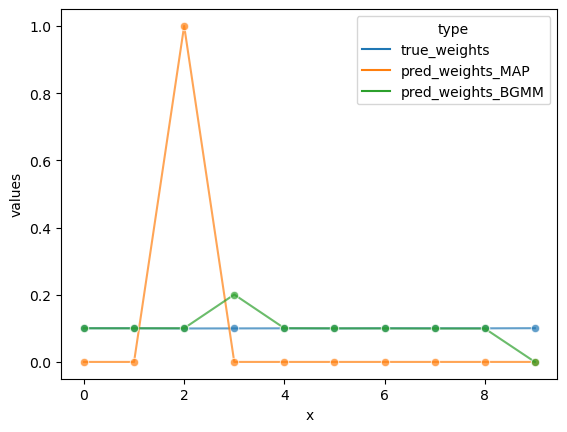

In [ ]:
sns.lineplot(data=weight_df_melted, x='x', y='values', hue='type', marker='o', alpha=0.7)

In [ ]:
# Compare the structures 
true_structure_MAP, pred_structure_MAP = assign_clusters(np.array(templates_flatten), np.array(pred_structure))

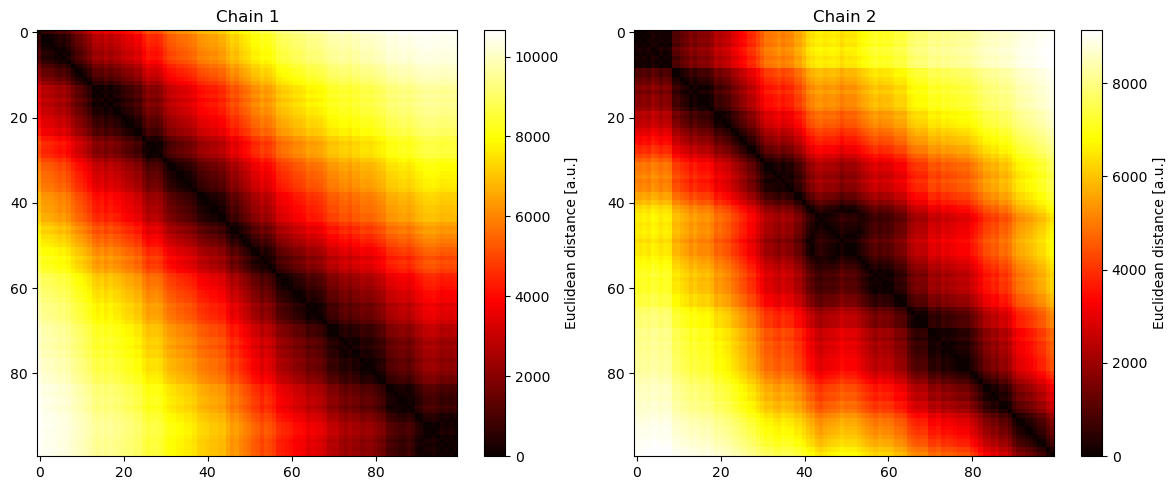

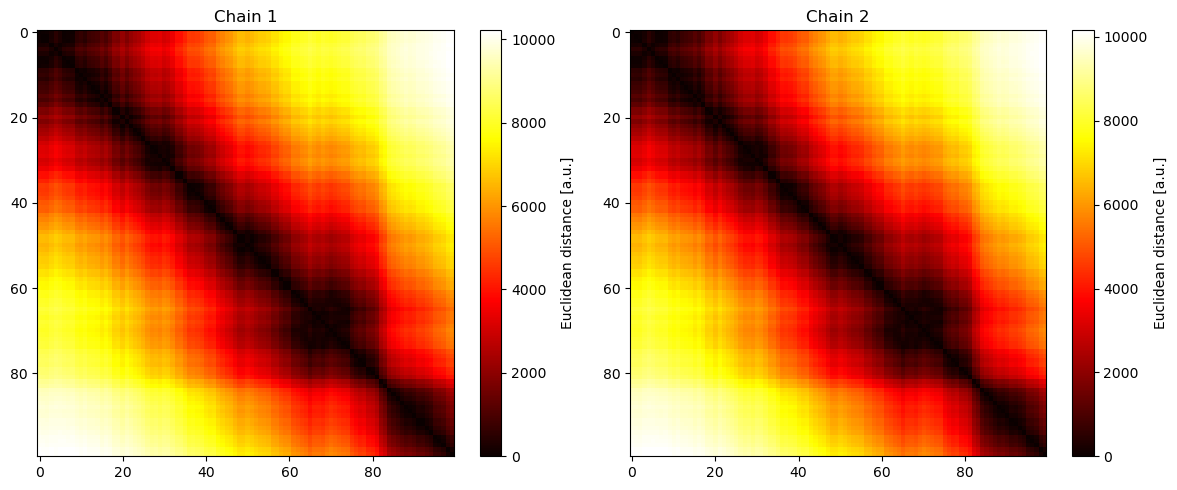

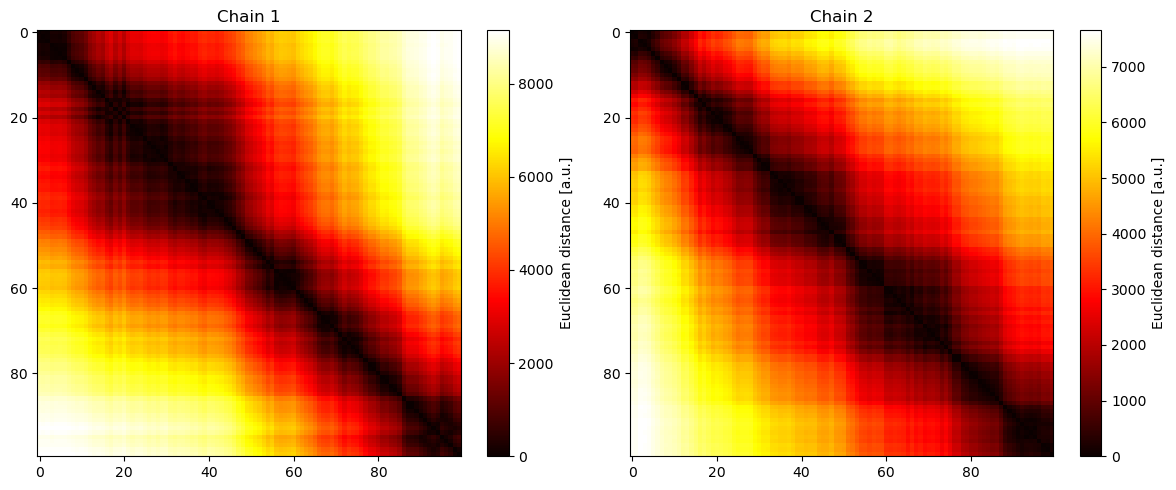

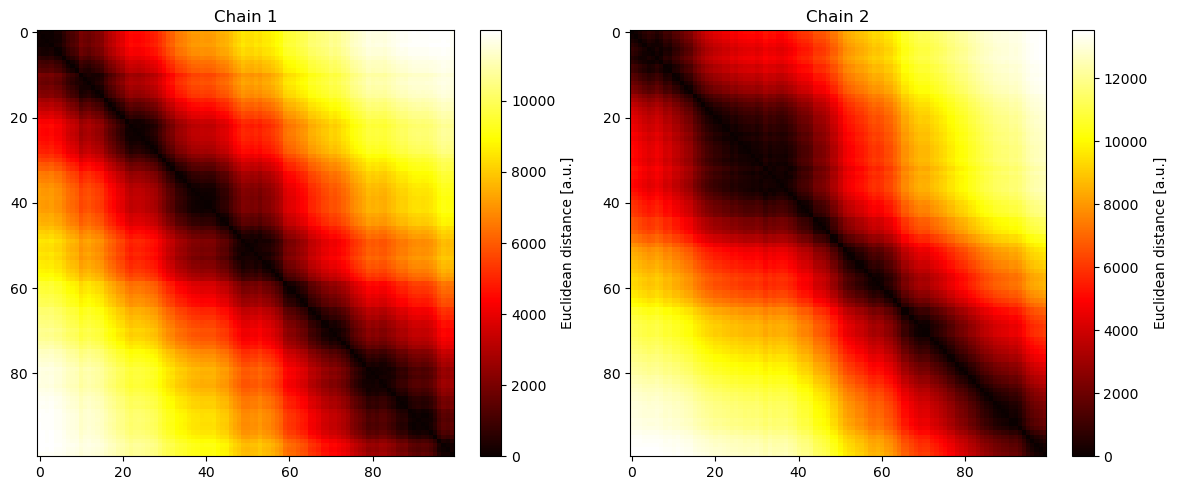

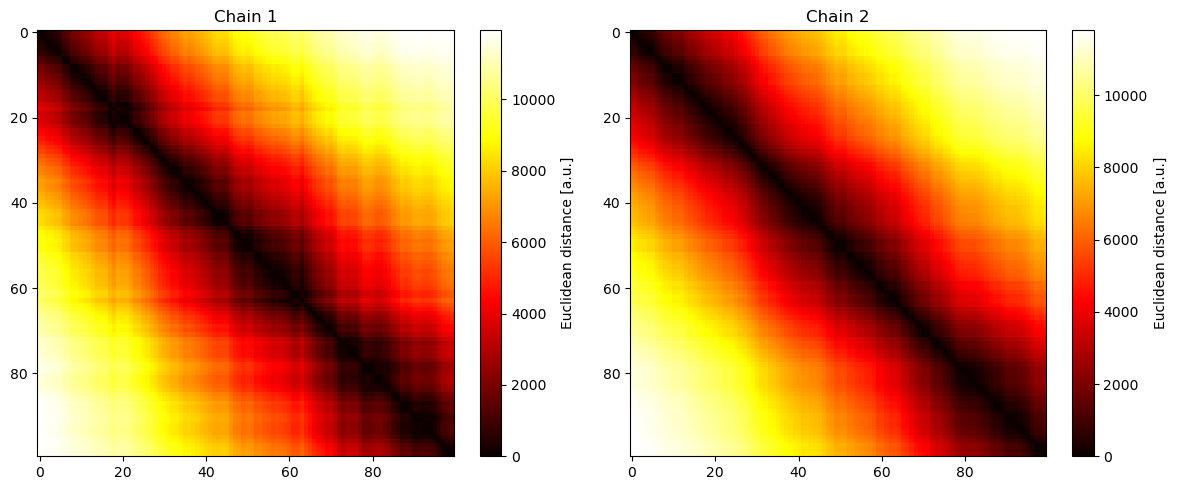

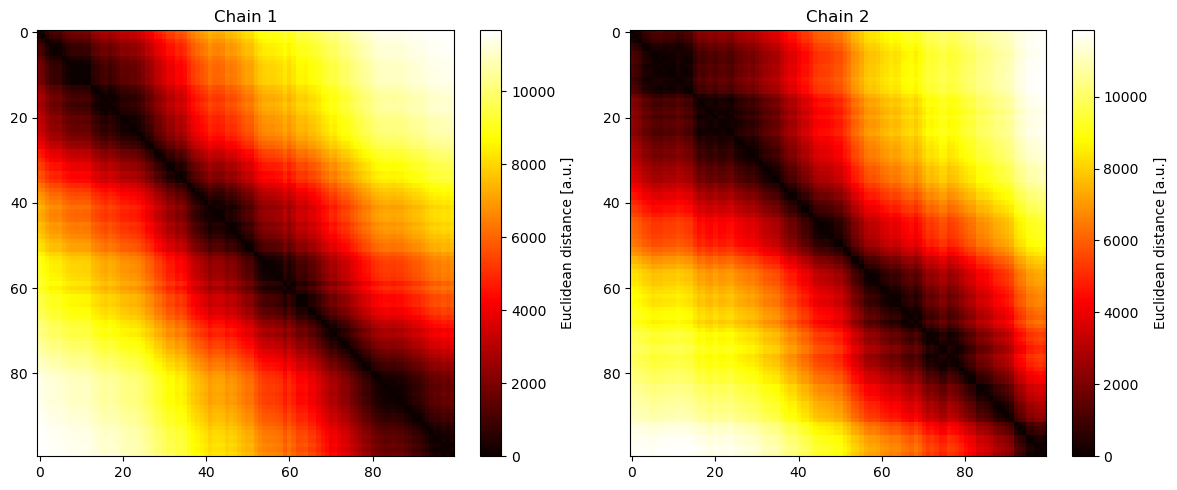

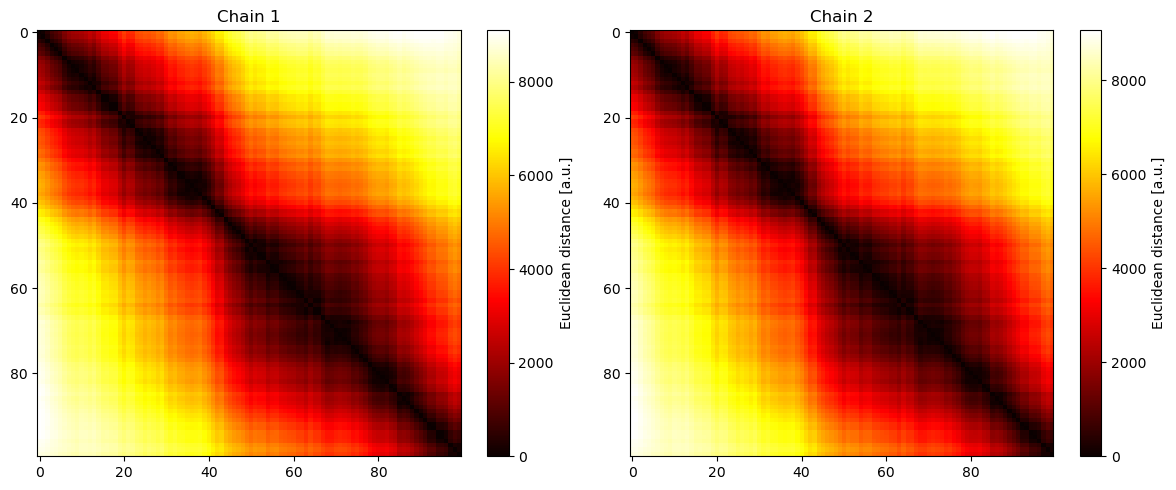

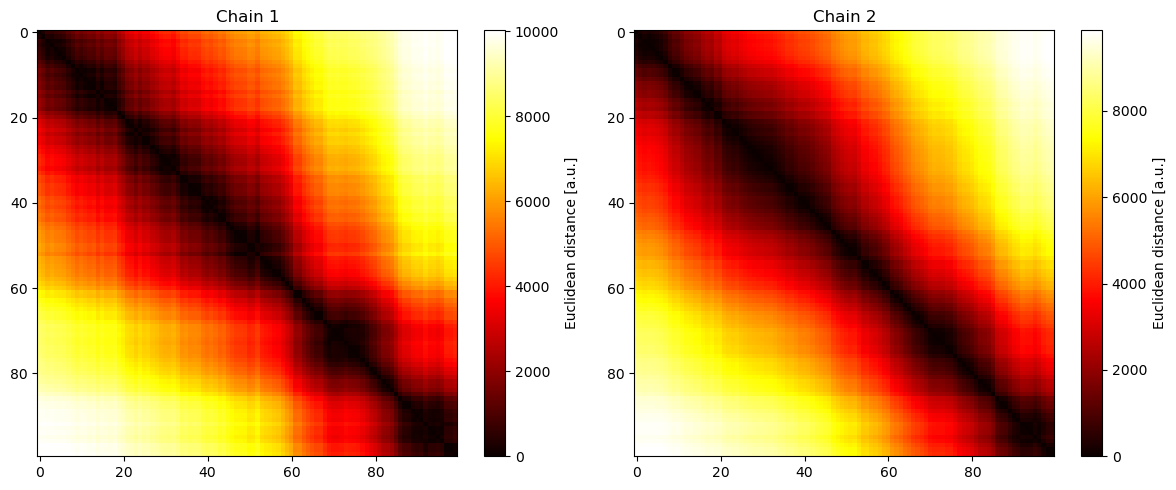

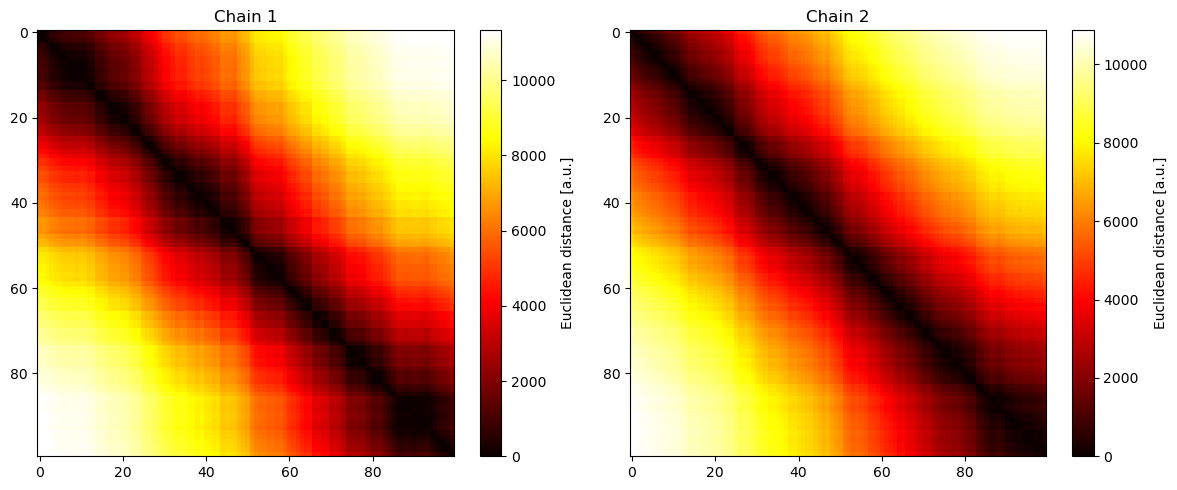

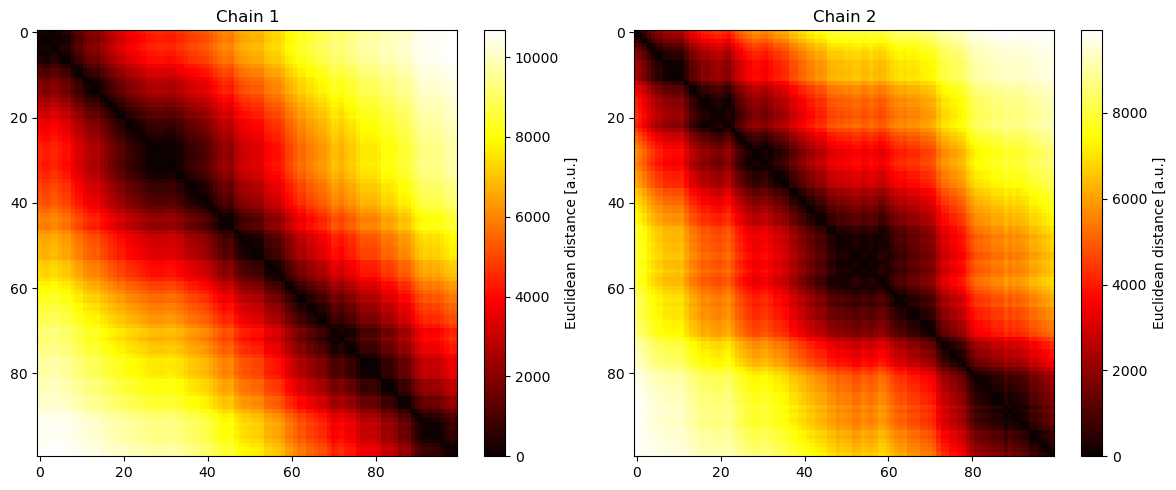

In [ ]:
for i in range(len(true_structure_MAP)):
    compare_distance_maps(true_structure_MAP[i].reshape(100, 100), pred_structure_MAP[i].reshape(100, 100))

In [ ]:
# Compare the structures 
true_structure_BGMM, pred_structure_BGMM = assign_clusters(np.array(templates_flatten), np.array(bgmm.means_))

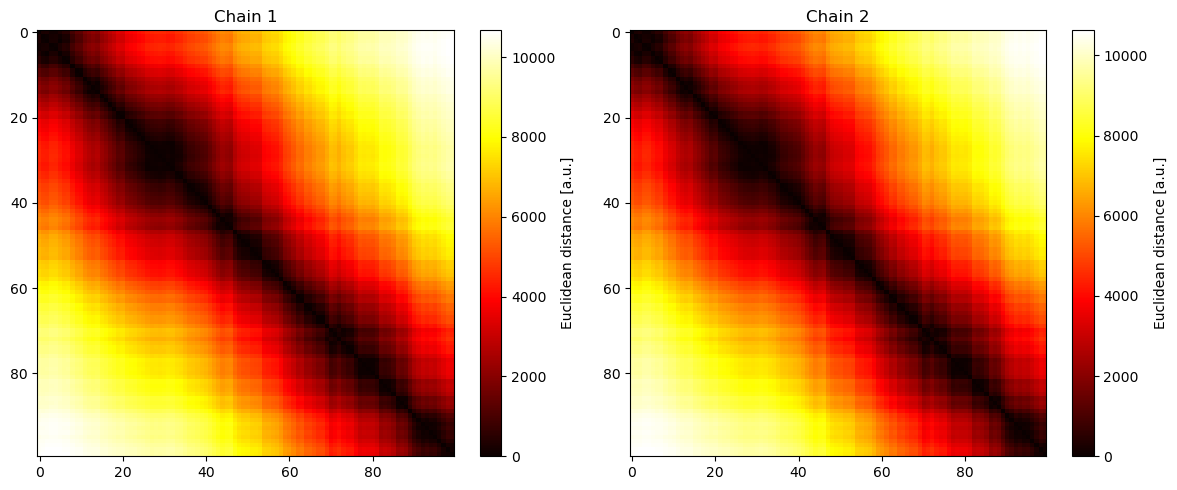

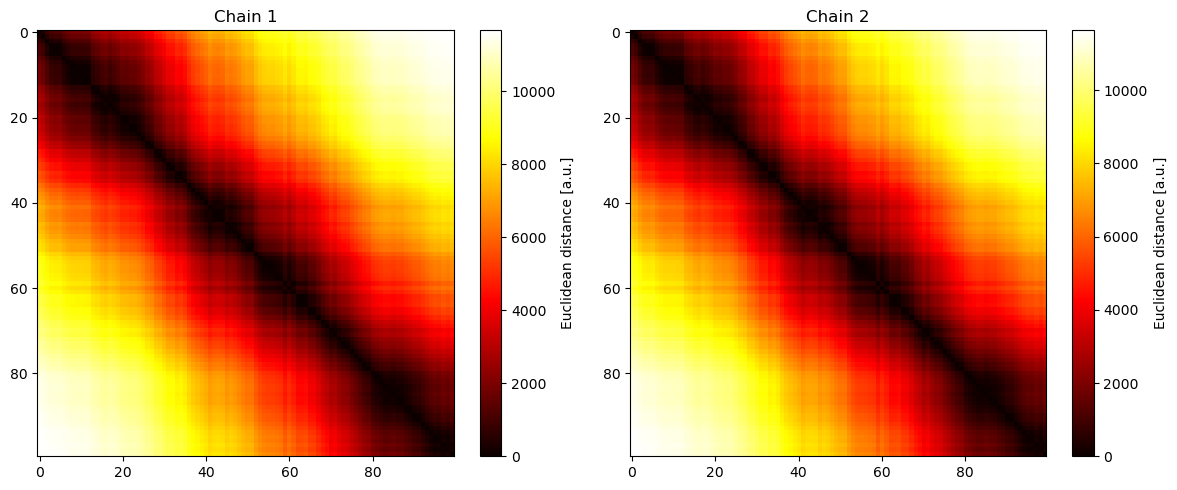

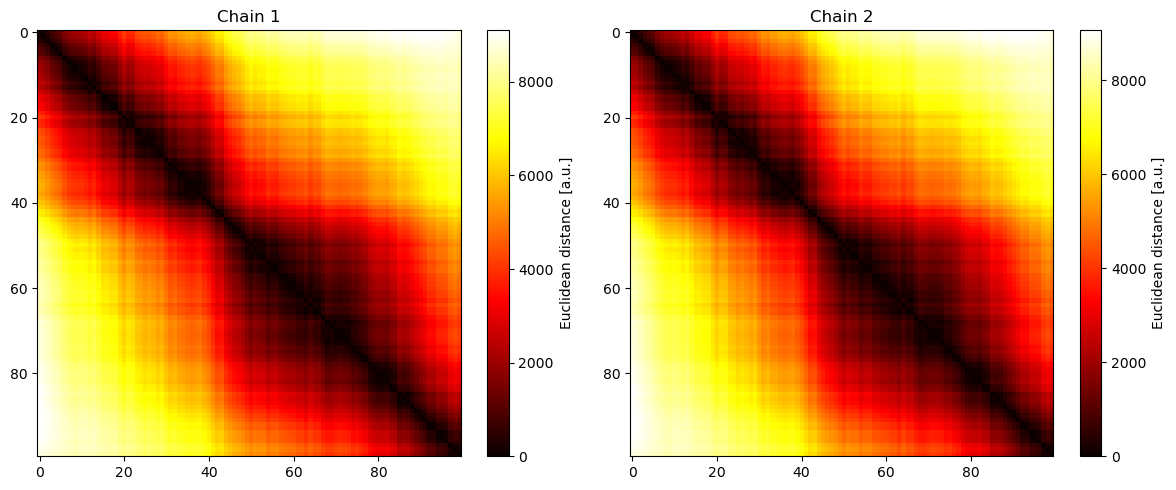

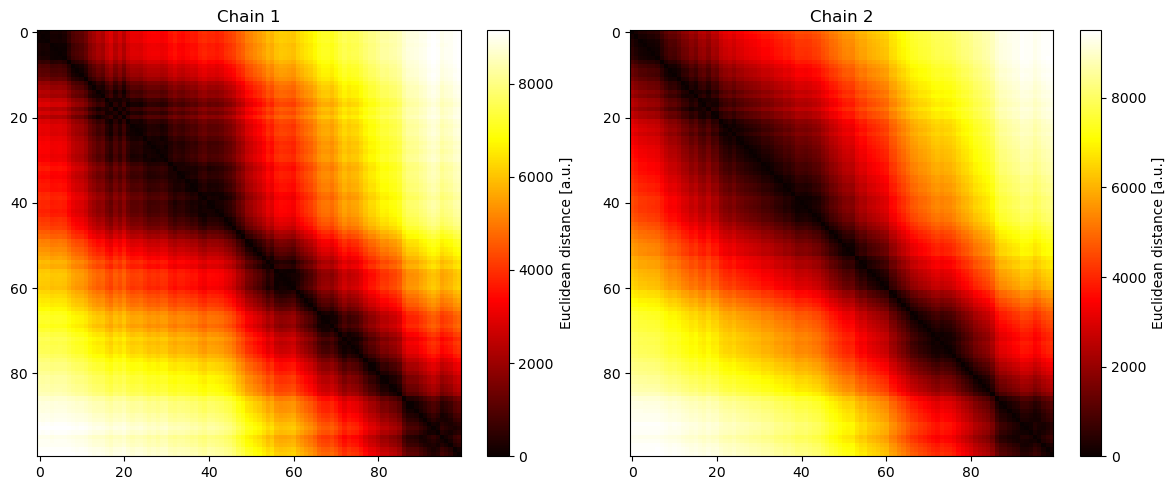

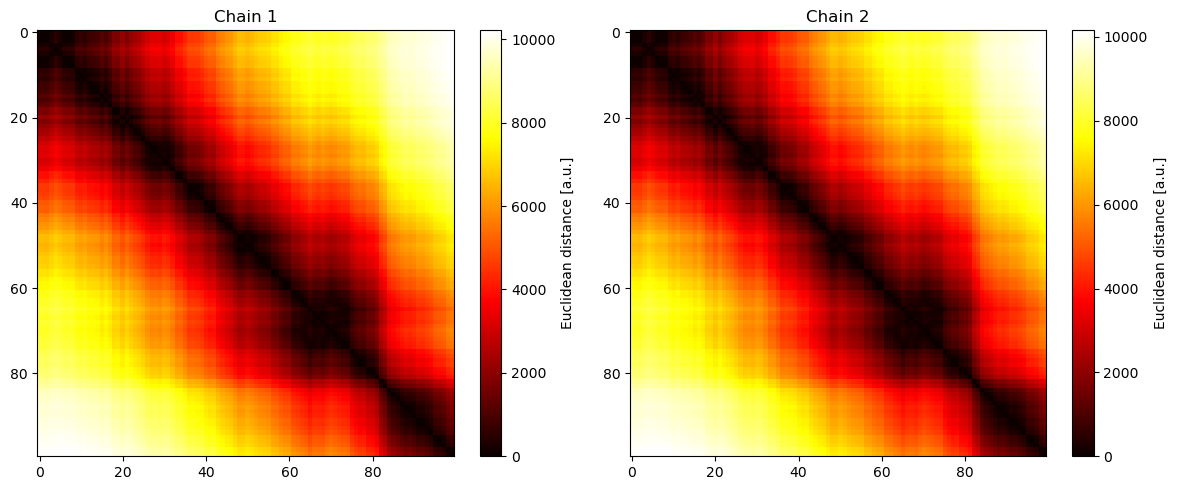

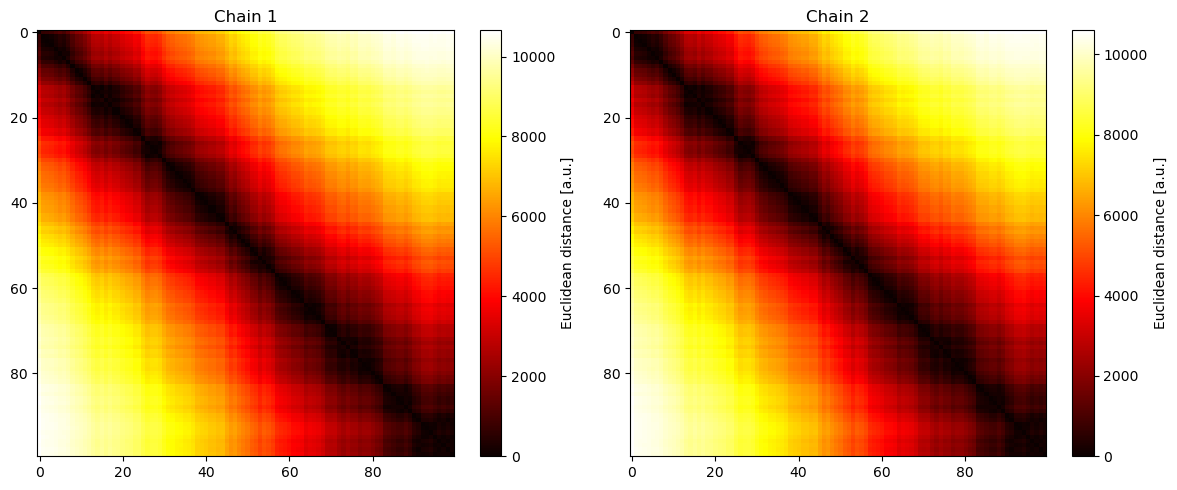

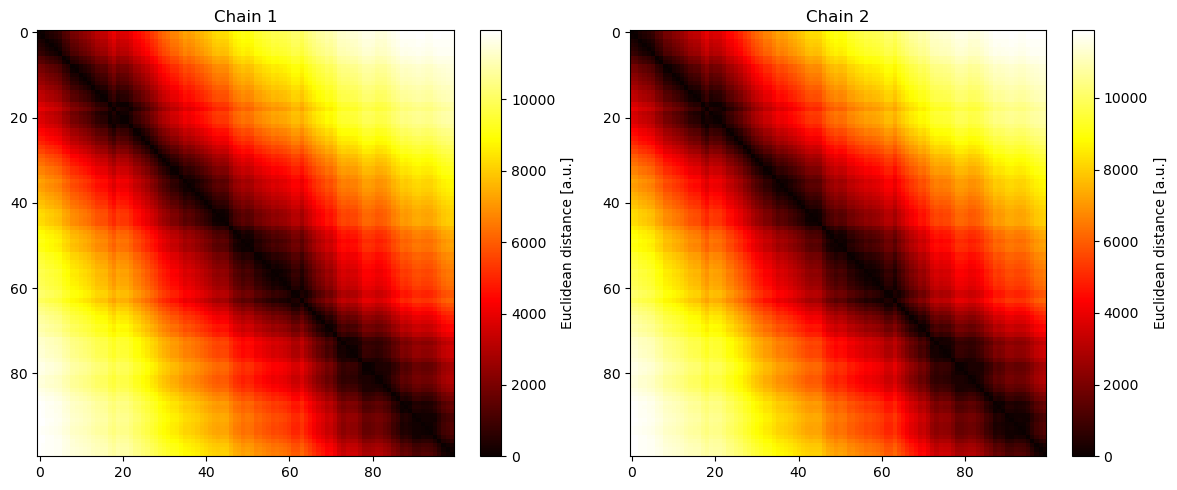

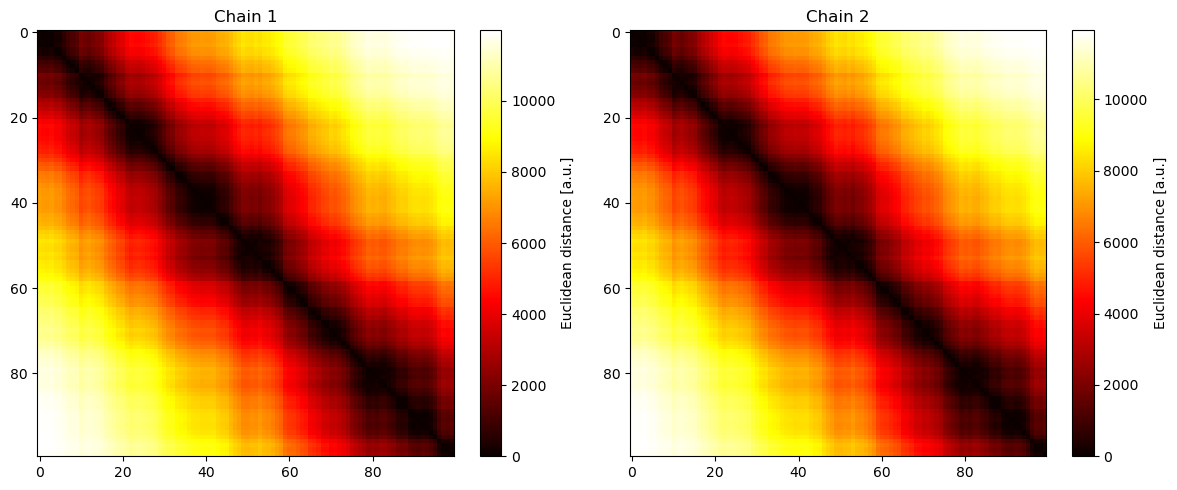

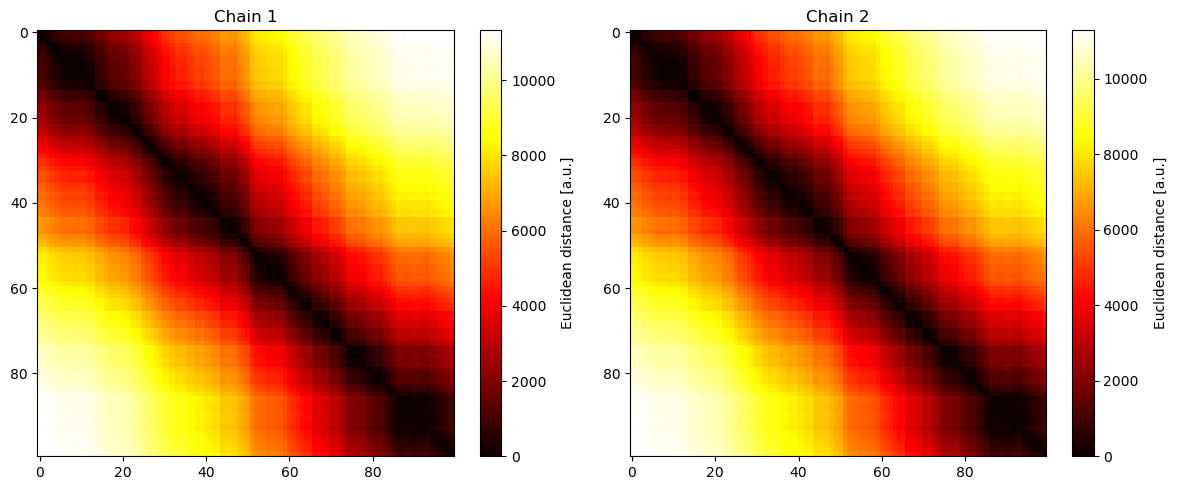

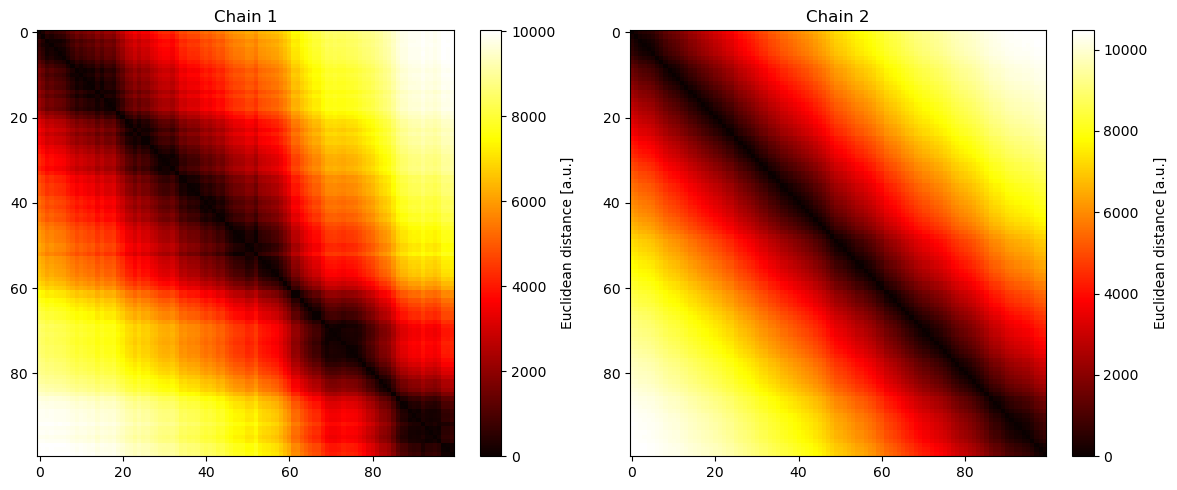

In [ ]:
for i in range(len(true_structure_BGMM)):
    compare_distance_maps(true_structure_BGMM[i].reshape(100, 100), pred_structure_BGMM[i].reshape(100, 100))

In [ ]:
import umap

In [ ]:
combined_dataset = np.vstack([np.array(templates_flatten), np.array(pred_structure_MAP), np.array(pred_structure_BGMM), np.array(observations_flatten)])

In [ ]:
umap_model = umap.UMAP(n_components=2)
umap_model.fit(combined_dataset)

/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [ ]:
templates_transform = umap_model.transform(np.array(templates_flatten))
pred_MAP_transform = umap_model.transform(np.array(pred_structure_MAP))
pred_BGMM_transform = umap_model.transform(np.array(pred_structure_BGMM))
observations_transform = umap_model.transform(np.array(observations_flatten))

In [ ]:
templates_df = pd.DataFrame({
    'x': templates_transform[:, 0],
    'y': templates_transform[:, 1],
    'type': 'templates'
})

pred_MAP_df = pd.DataFrame({
    'x': pred_MAP_transform[:, 0],
    'y': pred_MAP_transform[:, 1],
    'type': 'pred_MAP'
})

pred_BGMM_df = pd.DataFrame({
    'x': pred_BGMM_transform[:, 0],
    'y': pred_BGMM_transform[:, 1],
    'type': 'pred_BGMM'
})

observations_df = pd.DataFrame({
    'x': observations_transform[:, 0],
    'y': observations_transform[:, 1],
    'type': 'observations'
})

all_df = pd.concat([templates_df, pred_MAP_df, pred_BGMM_df, observations_df])

<Axes: xlabel='x', ylabel='y'>

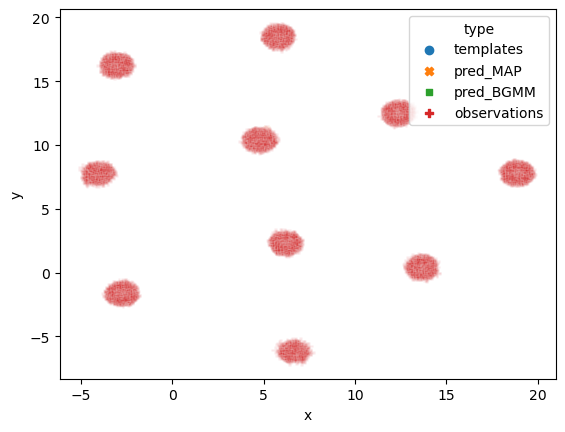

In [ ]:
sns.scatterplot(data=all_df, x='x', y='y', hue='type', style='type', alpha=0.7)

<Axes: xlabel='x', ylabel='y'>

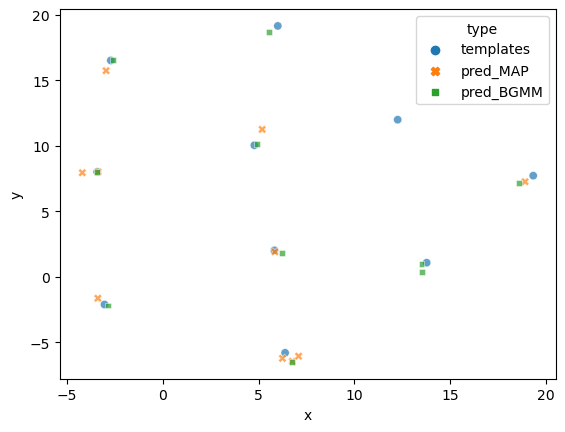

In [ ]:
sns.scatterplot(data=all_df[all_df.type != 'observations'], x='x', y='y', hue='type', style='type', alpha=0.7)